# Исследование технологического процесса очистки золота

## Подготовка данных

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.dummy import DummyRegressor

### Изучение данных

Считаем три датасета и рассмотрим, что в них содержится. Столбец `date` сделаем столбцом индексов.

In [2]:
data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv', index_col=0)
data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv', index_col=0)
data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv', index_col=0)

In [3]:
data_train.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           14148 non-null float64
final.output.concentrate_pb                           14148 non-null float64
final.output.concentrate_sol                          13938 non-null float64
final.output.concentrate_au                           14149 non-null float64
final.output.recovery                                 14149 non-null float64
final.output.tail_ag                                  14149 non-null float64
final.output.tail_pb                                  14049 non-null float64
final.output.tail_sol                                 14144 non-null float64
final.output.tail_au                                  14149 non-null float64
primary_cleaner.input.sulfate                         14129 non-null float64
primary_cleaner.input.depressant                      14117 non-null float64
primary_cleaner.i

In [5]:
train_shape = data_train.shape

Датасет `data_train`:
* состоит из 86 столбцов и 14 149 строк.
* Все объекты, кроме даты, числовые. Тип данных - `float`.
* Содержатся данные за 2.5 года: с 15.01.2016 по 18.08.2018.
* Есть пропущенные значения. Их обработаем ниже.

In [6]:
data_test.head()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [7]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
primary_cleaner.input.sulfate                 5286 non-null float64
primary_cleaner.input.depressant              5285 non-null float64
primary_cleaner.input.feed_size               5290 non-null float64
primary_cleaner.input.xanthate                5286 non-null float64
primary_cleaner.state.floatbank8_a_air        5290 non-null float64
primary_cleaner.state.floatbank8_a_level      5290 non-null float64
primary_cleaner.state.floatbank8_b_air        5290 non-null float64
primary_cleaner.state.floatbank8_b_level      5290 non-null float64
primary_cleaner.state.floatbank8_c_air        5290 non-null float64
primary_cleaner.state.floatbank8_c_level      5290 non-null float64
primary_cleaner.state.floatbank8_d_air        5290 non-null float64
primary_cleaner.state.floatbank8_d_level      5290 non-null float64
rougher.input.feed_ag                         529

In [8]:
test_shape = data_test.shape

Датасет `data_test`:
* состоит из 52 столбцов и 5 290 строк.
* Все объекты числовые. Тип данных - `float`.
* Содержатся данные за 2.5 года: с 01.09.2016 по 31.12.2017.
* Есть пропущенные значения, но их не более 10% от общего числа строк. Обработаем ниже.

In [9]:
data_full.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [10]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           19438 non-null float64
final.output.concentrate_pb                           19438 non-null float64
final.output.concentrate_sol                          19228 non-null float64
final.output.concentrate_au                           19439 non-null float64
final.output.recovery                                 19439 non-null float64
final.output.tail_ag                                  19438 non-null float64
final.output.tail_pb                                  19338 non-null float64
final.output.tail_sol                                 19433 non-null float64
final.output.tail_au                                  19439 non-null float64
primary_cleaner.input.sulfate                         19415 non-null float64
primary_cleaner.input.depressant                      19402 non-null float64
primary_cleaner.i

In [11]:
full_shape = data_full.shape

Датасет `data_full`:
* состоит из 86 столбцов и 19 439 строк.
* Все объекты числовые. Тип данных - `float`.
* Содержатся данные за 2.5 года: с 15.01.2016 по 18.08.2018.
* Есть пропущенные значения. Обработаем ниже.
* Все столбцы (признаки) разделены по стадиям обогащения золотосодержащей руды: `final`, `rougher`, `primary`, `secondary`. Далее по типу параметра на `input` — параметры сырья, `output` — параметры продукта, `state` — параметры, характеризующие текущее состояние этапа, `calculation` — расчётные характеристики.

<a id='no_test_columns'></a>
**Примечание:**
* тестовый датасет не содержит некоторых столбцов по сравнению с обучающим или исходным набором данных. Исследуем это далее.
* В качестве целевых признаков выступают `final.output.recovery` — эффективность обогащения финального концентрата, и `rougher.output.recovery` — эффективность обогащения чернового концентрата. которые нам необходимо научиться прогнозировать.

### Проверка эффективности обогащения

Проверим, что эффективность обогащения после флотации рассчитана правильно на обучающей выборке.

Эффективность обогащения после флотации рассчитывается по формуле:

Recovery = C * (F - T) / (F * (C - T)) * 100%,

где:
* C — доля золота в концентрате после флотации (`rougher.output.concentrate_au`);
* F — доля золота в сырье до флотации (`rougher.input.feed_au`);
* T — доля золота в отвальных хвостах после флотации (`rougher.output.tail_au`).

In [12]:
def recovery_calc(row):
    C = row['rougher.output.concentrate_au']
    F = row['rougher.input.feed_au']
    T = row['rougher.output.tail_au']
    return C * (F - T) / (F * (C - T)) * 100

In [13]:
df = pd.DataFrame()
df['rougher.output.recovery.calc'] = data_train.apply(recovery_calc, axis=1)

Расситаем *MAE* (*mean absolute error*) между значением признака и рассчитанными значениями.

In [14]:
df['rougher.output.recovery.mae'] = mean_absolute_error(
    data_train['rougher.output.recovery'], df['rougher.output.recovery.calc']
)

In [15]:
print('Среднее значение MAE:', df['rougher.output.recovery.mae'].mean())

Среднее значение MAE: 9.68289614782555e-15


Среднее значение *MAE* получилось очень маленьким. Это говорит о том, что в обучающей выборке (а значит, и в исходных данных тоже) значения эффективности обогащения после флотации представлены верно.

### Анализ признаков в датасетах

Как было выявлено в [разделе 1.1](#no_test_columns), в тестовом наборе данных отсутствуют некоторые признаки, которые есть в двух других наборах. Определим, чего не хватает.

Признаки, которые есть в `data_train`, но нет в `data_test`:

In [16]:
train_test_diff = data_train.columns.difference(data_test.columns)
print(train_test_diff)

Index(['final.output.concentrate_ag', 'final.output.concentrate_au',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au',
       'final.output.tail_pb', 'final.output.tail_sol',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au',
       'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
       'rougher.calculation.au_pb_ratio',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_au',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'roughe

Признаки, которые есть в `data_full`, но нет в `data_test`:

In [17]:
full_test_diff = data_full.columns.difference(data_test.columns)
print(full_test_diff)

Index(['final.output.concentrate_ag', 'final.output.concentrate_au',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au',
       'final.output.tail_pb', 'final.output.tail_sol',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au',
       'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
       'rougher.calculation.au_pb_ratio',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_au',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'roughe

Проверим, что в `data_full` и `data_train` признаки совпадают:

In [18]:
train_test_diff.difference(full_test_diff)

Index([], dtype='object')

Получается, что в тестовой выборке отсутствуют:
* признаки, которые есть в исходном и обучающем наборе данных. Это выходные значения содержания золота и примесей в концентратах и отвальных хвостах на каждой стадии обработки руды;
* расчетные характеристики флотационных установок: `rougher.calculation.sulfate_to_au_concentrate`, `rougher.calculation.floatbank10_sulfate_to_au_feed`, `rougher.calculation.floatbank11_sulfate_to_au_feed`, `rougher.calculation.au_pb_ratio`;
* целевые признаки `final.output.recovery` и `rougher.output.recovery`.

Поскольку в продакшене ML модель будет работать с тестовым набором данных, аналогичным тому, с которым мы работаем сейчас, то обучающую выборку нужно обработать, удалив столбцы (признаки), которых нет в тестовой выборке. Сделаем это [в дальнейшем](#sample_) после предобработки и анализа обучающей выборки.

Будем далее работать именно с обучающей выборкой, чтобы потом сразу перейти с ней к обучению моделей.

### Предобработка данных

Проведите предобработку данных на обучающей выборке:
* удалим дубликаты, если они имеются;
* обработаем пропущенные значения.

Признаки, отсутствующие в тестовой выборке, удалим из обучающей после анализа данных — перед тем, как будем обучать ML модели.

#### Обработка дубликатов

Проверим, есть ли дубликаты в обучающей выборке.

In [19]:
data_train.duplicated().sum()

0

Дубликатов нет.

#### Обработка пропусков

Оценим, сколько пропущенных значений есть в обучающей выборке.

In [20]:
data_train.isna().sum().sum()

4100

Количество пропущенных значений составляет суммарно чуть менее 30% от всего обучающего набора данных.

Удалим объекты (строки), в которых пропущенных значений меньше 1% (меньше 100). Для этого создадим датафрейм из столбцов, для которых значения isna().sum() удовлетворяют этому условию.

In [21]:
tc = data_train.isna().sum()
tc = tc.to_frame(name='na_sum')

In [22]:
tc_less_100 = tc[tc['na_sum'] <= 100]

In [23]:
data_train = data_train.dropna(subset=tc_less_100.index.to_list())

Заполним оставшиеся пропущенные значения с помощью метода `ffill`: он заполнит каждый текущий пропуск предыдущим имеющимся значением.

In [24]:
data_train = data_train.ffill(axis=1)

Проверим на пропуски снова и оценим изменение размера обучающей выборки после преобразований.

In [25]:
print('Количество пропущенных данных:', data_train.isna().sum().sum())
print('Обучающая выборка уменьшилась на {:.1f} %'.format(
    (train_shape[0] - data_train.shape[0]) / train_shape[0] * 100)
     )

Количество пропущенных данных: 0
Обучающая выборка уменьшилась на 3.6 %


### Выводы

* Изучены исходные данные, проведен их первичный анализ.
* Даты в каждом наборе сделаны индексами для удобства работы.
* Работа идет в основном с обучающим датафреймом. Проведена предобработка данных: пропущенные значения в были заполнены с помощью метода `ffill`, проверены дубликаты. Обучающая выборка уменьшилась после предобработки на 3.6% по сравнению с исходной.
* Проанализированы признаки, содержащиеся во всех исходных данных. Выявлено, что тестовый набор содержит меньшее число признаков.
* Проведена проверка эффективности обогащения руды: Сседнее значение *MAE* получилось очень маленьким. Это говорит о том, что в обучающей выборке (а значит, и в исходных данных тоже) значения эффективности обогащения после флотации представлены верно.

## Анализ данных

### Изменение концентрации *Ме*

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки для каждого из них. Напишем пользовательскую функцию, которая будет строить гистограммы по имеющимся данным.

In [26]:
def hist_draw(df, cols, hist_title, parameters):
    for key in cols:
        ax = df[key].hist(
            bins=parameters['bins'],
            range=parameters['range'],
            alpha=parameters['alpha'],
            label=cols[key],
            figsize=(10,4)
        )
    plt.title(hist_title)
    plt.xlabel('Концентрация металлов')
    plt.ylabel('Частота')
    ax.legend()
    plt.show()

Для каждого этапа зададим следующие параметры.

In [27]:
parameters = {'bins': 100, 'range': (0, 55), 'alpha': 0.5}

In [28]:
cols_0 = {'rougher.input.feed_au': 'Au',
          'rougher.input.feed_ag': 'Ag',
          'rougher.input.feed_pb': 'Pb'}
hist_title_0 = 'Концентрация металлов в смеси до флотации'

In [29]:
cols_1 = {'rougher.output.concentrate_au': 'Au',
          'rougher.output.concentrate_ag': 'Ag',
          'rougher.output.concentrate_pb': 'Pb'}
hist_title_1 = 'Концентрация металлов в смеси после флотации'

In [30]:
cols_2 = {'primary_cleaner.output.concentrate_au': 'Au',
          'primary_cleaner.output.concentrate_ag': 'Ag',
          'primary_cleaner.output.concentrate_pb': 'Pb'}
hist_title_2 = 'Концентрация металлов в смеси после первого этапа очистки'

In [31]:
cols_3 = {'final.output.concentrate_au': 'Au',
          'final.output.concentrate_ag': 'Ag',
          'final.output.concentrate_pb': 'Pb'}
hist_title_3 = 'Концентрация металлов в смеси после всех этапов'

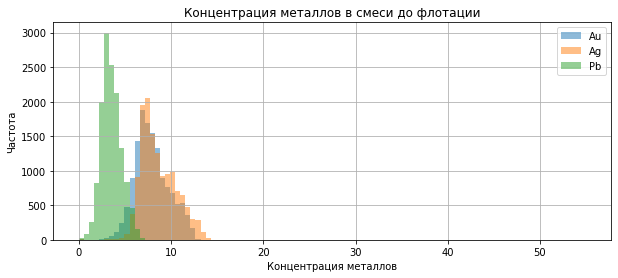

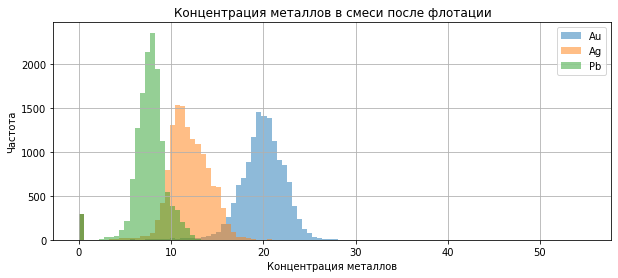

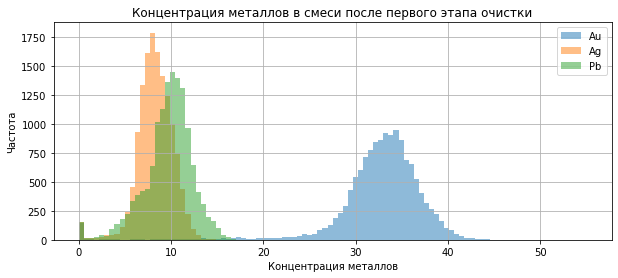

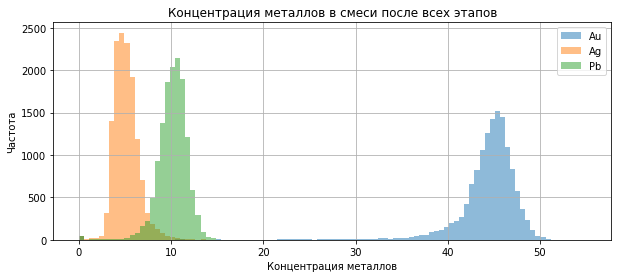

In [32]:
hist_draw(data_train, cols_0, hist_title_0, parameters)
hist_draw(data_train, cols_1, hist_title_1, parameters)
hist_draw(data_train, cols_2, hist_title_2, parameters)
hist_draw(data_train, cols_3, hist_title_3, parameters)

Из гистограмм видно, что:
* на каждом этапе концентрация золота растет и на финальной стадии достигает в среднем 45%;
* концентрации серебра и свинца также меняются на каждой стадии, что связано с химико-технологическими процессами получения золота из руды;
* в распределениях присутствуют пиковые значения на нулевых концентрациях. Эти значения могут быть связаны со сбоями в технологическом процессе или сбоями измерительного оборудования. Они будут влиять на качество прогнозов, поэтому от них нужно избавиться.

Обработаем нулевые значения, удалив их обучающего набора данных. Для начала создадим перечень всех столбцов с концентрациями металлов, объединив уже имеющиеся словари.

In [33]:
cols = {**cols_0, **cols_1, **cols_2, **cols_3}
cols_list = list(cols.keys())

С помощью функции удалим все объекты из обучающей выборки, для которых концетрация золота, серебра и свинца на каждом этапе меньше 1%.

In [34]:
def del_null_conc(cols_list, df):
    for element in cols:
        df = df.drop(df[df[element] <= 1].index)
    return df

In [35]:
data_train = del_null_conc(cols_list, data_train)

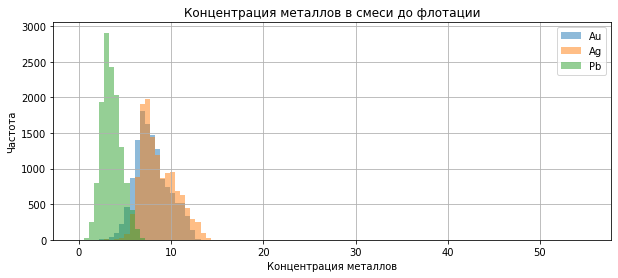

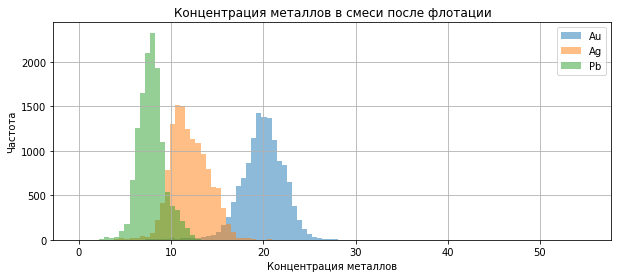

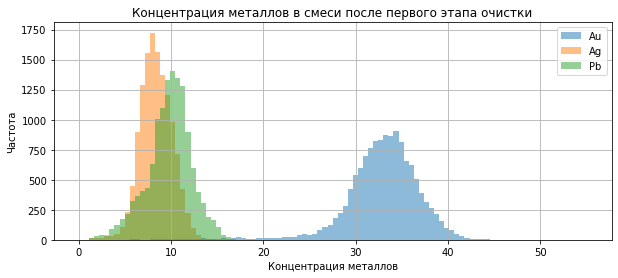

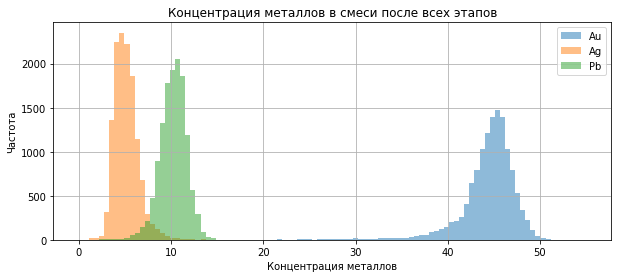

In [36]:
hist_draw(data_train, cols_0, hist_title_0, parameters)
hist_draw(data_train, cols_1, hist_title_1, parameters)
hist_draw(data_train, cols_2, hist_title_2, parameters)
hist_draw(data_train, cols_3, hist_title_3, parameters)

### Распределение размеров гранул

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках. В качестве параметра выступает `rougher.input.feed_size` — размер гранул сырья перед этапом флотации.

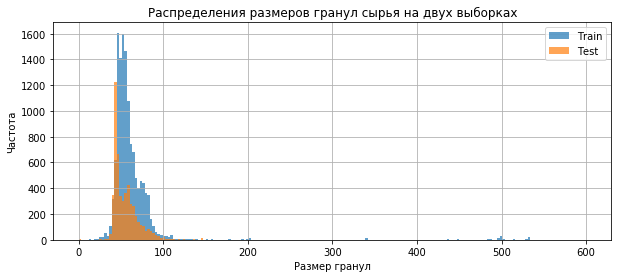

In [37]:
data_train['rougher.input.feed_size'].hist(bins=200, range=(0, 600), alpha=0.7, label='Train', figsize=(10,4))
data_test['rougher.input.feed_size'].hist(bins=200, range=(0, 600), alpha=0.7, label='Test', figsize=(10,4))
plt.title('Распределения размеров гранул сырья на двух выборках')
plt.xlabel('Размер гранул')
plt.ylabel('Частота')
plt.legend()
plt.show()

Из гистограммы видно, что есть выбросы размеров гранул со значениями свыше 300. Удалим эти выбросы из обучающией выборки.

In [38]:
data_train = data_train.drop(data_train[data_train['rougher.input.feed_size'] > 300].index)

Оценим попутно, насколько уменьшилась обучающая выборка по сравнению с исходной обучающей выборкой, загруженной из файла:

In [39]:
print('Обучающая выборка уменьшилась на {:.1f} %'.format(
    (train_shape[0] - data_train.shape[0]) / train_shape[0] * 100)
     )

Обучающая выборка уменьшилась на 8.8 %


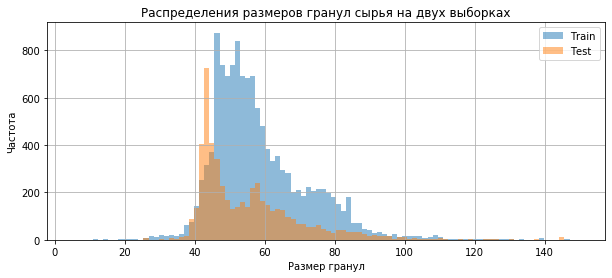

In [40]:
data_train['rougher.input.feed_size'].hist(bins=100, range=(5, 150), alpha=0.5, label='Train', figsize=(10,4))
data_test['rougher.input.feed_size'].hist(bins=100, range=(5, 150), alpha=0.5, label='Test', figsize=(10,4))
plt.title('Распределения размеров гранул сырья на двух выборках')
plt.xlabel('Размер гранул')
plt.ylabel('Частота')
plt.legend()
plt.show()

Построим графики плотности распределений для размера гранулы на двух выборках. Такие графики сглаживают гистограмму и позволяют легче оценить форму, симметрию / ассиметрию и центр распределений.

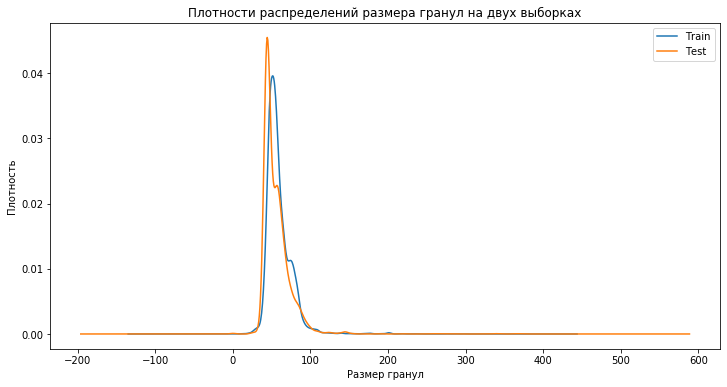

In [41]:
data_train['rougher.input.feed_size'].plot.kde(figsize=(12,6), label='Train')
data_test['rougher.input.feed_size'].plot.kde(label='Test')
plt.title('Плотности распределений размера гранул на двух выборках')
plt.xlabel('Размер гранул')
plt.ylabel('Плотность')
plt.legend()
plt.show()

Как видно из графиков, распределения отличаются друг от друга, но не сильно. Особенности распределений в сравнении:
* для обеих выборок распределения бимодальные;
* моды смещены друг относительно друга несущественно; возможно, это следствие разбиения исходных данных.

Оценим еще распределения размера гранул в двух выборках с помощью элементов описательной статистики.

In [42]:
data_train['rougher.input.feed_size'].describe()

count    12902.000000
mean        59.293202
std         16.985649
min          9.659576
25%         49.008666
50%         55.343217
75%         65.695108
max        299.098260
Name: rougher.input.feed_size, dtype: float64

In [43]:
data_test['rougher.input.feed_size'].describe()

count    5289.000000
mean       55.951097
std        19.081758
min         0.046369
25%        43.906347
50%        50.841029
75%        62.431047
max       392.494040
Name: rougher.input.feed_size, dtype: float64

* Видно, что оба набора данных очень похожи по параметрам описательной статистики: средние значения, СКО, медианы и максимальные значения размера гранула в выборках достаточно близки по значениям.
* В среднем на вход перед началом обработки руды стараются подавать гранулы размером 55 (в тестовой выборке) и 59 (в обучающей выборке) усл. ед.
* В обучающей выборке чаще всего встречаются гранулы размером 55 усл. ед., а в тестовой - 50 усл. ед.

### Суммарная концетрация веществ

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Искомые вещества — золото, серебро, свинец и соли металлов. Будем рассматривать по-прежнему обучающую выборку. Для расчета воспользуемся уже имеющимся вспомогательным датафреймом.

In [44]:
df['rougher.input.feed.calc'] = data_train[[
    'rougher.input.feed_ag',
    'rougher.input.feed_au',
    'rougher.input.feed_pb',
    'rougher.input.feed_sol']].sum(axis=1)

In [45]:
df['rougher.output.concentrate.calc'] = data_train[[
    'rougher.output.concentrate_ag',
    'rougher.output.concentrate_au',
    'rougher.output.concentrate_pb',
    'rougher.output.concentrate_sol']].sum(axis=1)

In [46]:
df['final.output.concentrate.calc'] = data_train[[
    'final.output.concentrate_ag',
    'final.output.concentrate_au',
    'final.output.concentrate_pb',
    'final.output.concentrate_sol']].sum(axis=1)

Визуализуруем на гистограммах эти расчеты.

In [47]:
conc_me = {'rougher.input.feed.calc': 'Сырье',
           'rougher.output.concentrate.calc': 'Черновой концентрат',
           'final.output.concentrate.calc': 'Финальный концентрат'}
hist_title_me = 'Суммарная концентрация вещества на разных стадиях'

In [48]:
parameters = {'bins': 120, 'range': (10, 90), 'alpha': 0.5}

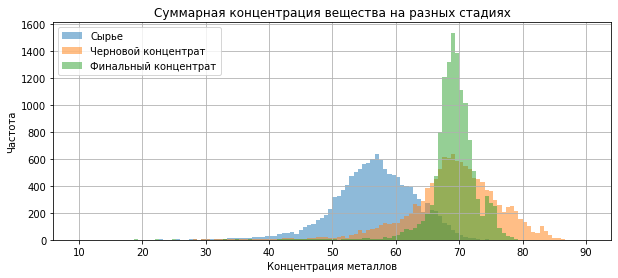

In [49]:
hist_draw(df, conc_me, hist_title_me, parameters)

Из гистограмм видно, что:
* концентрация металлов в сырье, которое представляет собой дробленую смесь после первичной обработки добытой руды, в среднем составляет 56% об общего объема (или массы) смеси;
* после флотации концентрация металлов в черновом концентрате увеличивается и в среднем достигает 69%. Это связано с тем, что часть входного продукта с низкой концентрацией ценных металлов отделяется в виде "отвальных хвостов";
* распределения концентраций сырья до флотации и чернового концентрата, полученного после нее, сильно похожи по форме и размаху;
* суммарная концентрация металлов в финальном концентрате после двух этапов очистки в среднем составляет так же 69%. Однако само распределение становится более узким.

### Выводы

* Исследовано изменение концентрации ценных металлов на разных стадиях обработки руды. Визуализация данных хорошо отображает процесс увеличения концентрации золота в смеси на каждой стадии. Удалены значения, соответствующие нулевой концетрации металлов.
* Исследовано распределение гранул сырья в обучающей и тестовой выборке. Результаты показывают, что по этому параметру выборки достаточно схожи. На этом этапе анализа из обучающей выборки также были удалены выбросы размеров гранул свыше 300 ед. Выборка вследствие этого уменьшилась на 8.8% по сравнению с исходной, что вполне допустимо.
* Исследована суммарная концетрация веществ на разных стадиях: аномалий не выявлено, изменение концентрации вполне адекватно отражает физический процесс обработки руды.

## Модель

<a id='sample_'></a>
### Обработка выборок

Удалим из обучающей выборки те признаки, которые отсутствуют в тестовой выборке, чтобы модель могла обучиться на одинаковом наборе признаков и выдавала заведомо более качественный результат.

Создадим список столбцов, которые нам не нужны в обучающей выборке, поскольку их нет в тестовой выборке.

In [50]:
columns_diff = train_test_diff.tolist()

Удалим из списка целевые признаки — они нам нужны в обучающей выборке.

In [51]:
columns_diff.remove('rougher.output.recovery')
columns_diff.remove('final.output.recovery')

Создадим новую обучающую выборку.

In [52]:
train = data_train.drop(columns_diff, axis=1)

In [53]:
train.shape

(12902, 54)

Преобразованная обучающая выборка состоит из 54 признаков вместо исходных 86. Тестовая выборка состоит из 52 признаков, как было показано в разделе 1.1.

Оценим корелляцию признаков в обучающем наборе до разделения на два датафрейма.

Text(0.5, 1, 'Матрица корреляции для обучающей выборки')

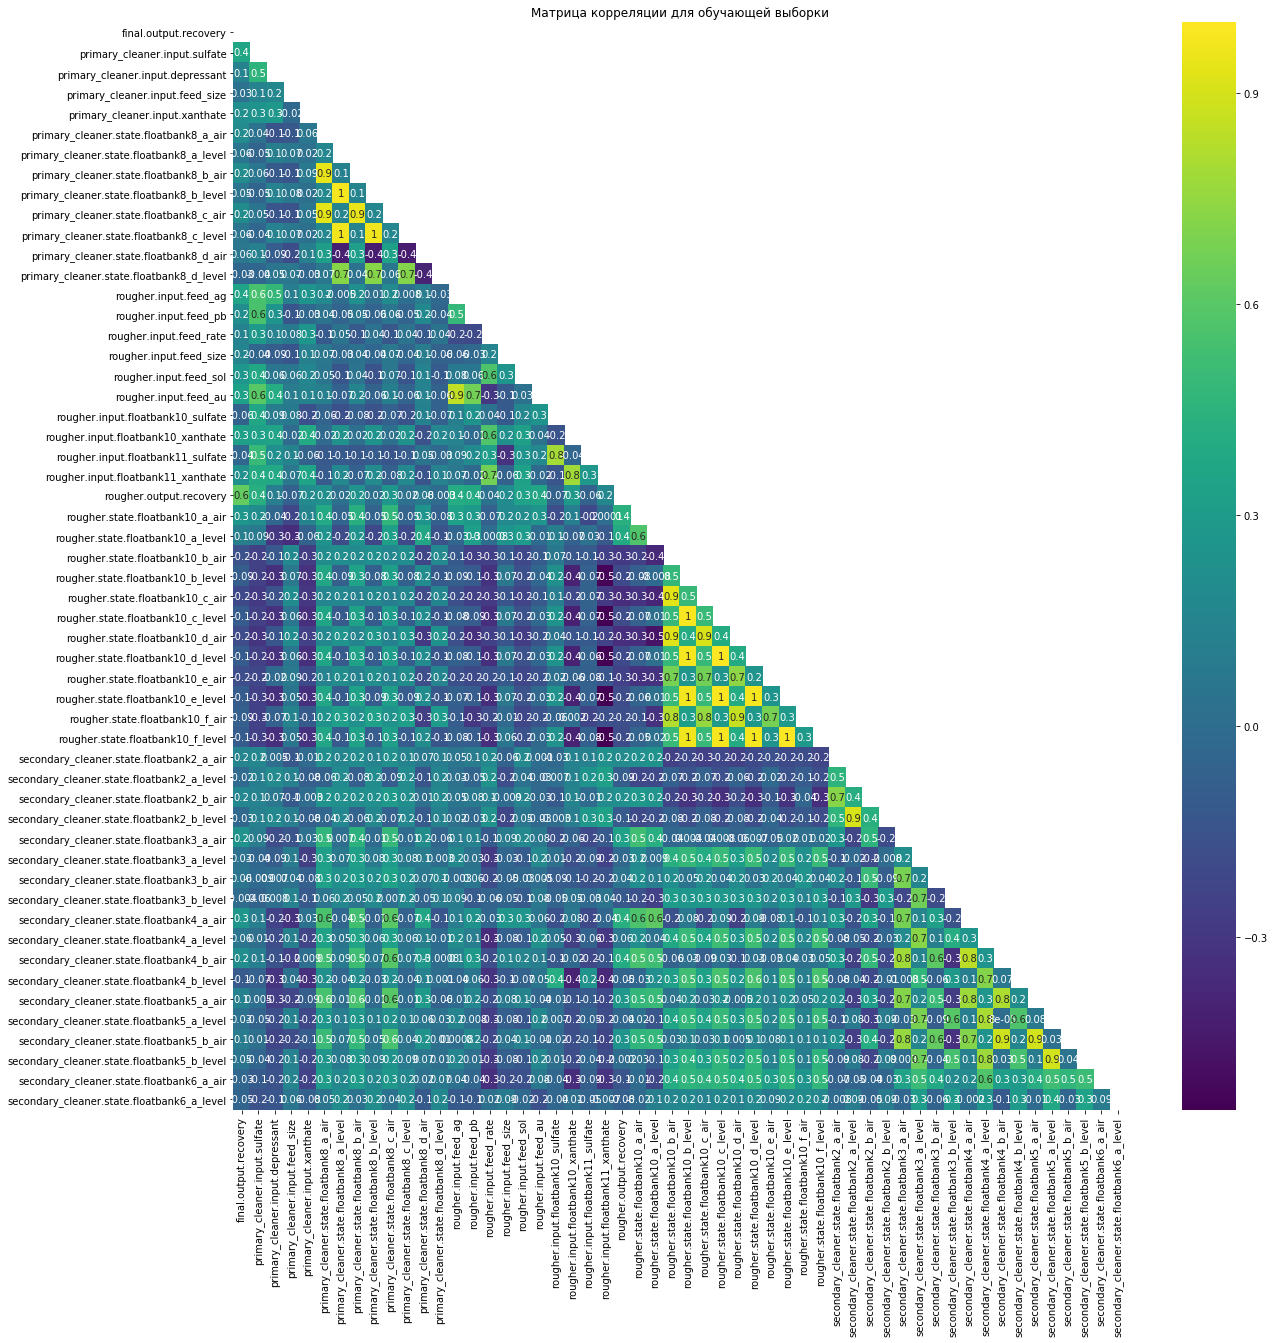

In [54]:
plt.figure(figsize = (20,20))
matrix = np.triu(train.corr())
sns.heatmap(train.corr(), annot=True, mask=matrix, cmap= 'viridis', fmt='.1g')
plt.title('Матрица корреляции для обучающей выборки')

Видно, что наиболее сильная корелляция проявляется между признаками, связанными с:
* параметрами флотационных установок на разных стадиях техпроцесса;
* концентрацией золота и серебра перед флотацией.

Для целевых признаков яркая линейная зависимость от других признаков не выявлена.

Выделим в обучающей выборке признаки и целевые признаки. В качестве целевых признаков выступают `final.output.recovery` и `rougher.output.recovery`.

In [55]:
target_features = ['rougher.output.recovery', 'final.output.recovery']

In [56]:
features = train.drop(target_features, axis=1)
targets = train[target_features]

In [57]:
print("Размерность выборки с признаками:", features.shape)
print("Размерность выборки с целевыми признаками: ", targets.shape)

Размерность выборки с признаками: (12902, 52)
Размерность выборки с целевыми признаками:  (12902, 2)


Тестовую выборку заранее обработаем единственно в части заполнения пропущенных значений с помощью методов `ffill` и `bfill`.

In [58]:
test = data_test.ffill(axis=1)
test = test.bfill(axis=1)

In [59]:
test.isna().sum().sum()

0

In [60]:
print("Размерность тестовой выборки:", test.shape)

Размерность тестовой выборки: (5290, 52)


### Функция для sMAPE

Напишем функцию для вычисления метрики sMAPE в абсолютных единицах (не процентах). Метрика качества sMAPE (англ. *Symmetric Mean Absolute Percentage Error*) — симметричное среднее абсолютное процентное отклонение.

In [61]:
def smape_calc(y_true, y_pred):
    y_true_rougher  = y_true[:, 0]
    y_true_final = y_true[:, 1]
    y_pred_rougher = y_pred[:, 0]
    y_pred_final = y_pred[:, 1]
    smape_rougher = 1 / len(y_true_rougher) * np.sum(2 * np.abs(y_true_rougher - y_pred_rougher)
                                                     / (np.abs(y_true_rougher) + np.abs(y_pred_rougher)))
    smape_final = 1 / len(y_true_final) * np.sum(2 * np.abs(y_true_final - y_pred_final)
                                                 / (np.abs(y_true_final) + np.abs(y_pred_final)))
    return 0.25 * smape_rougher + 0.75 * smape_final

Сделаем из этой функции объект, который сможем использовать при оценке качества ML моделей в *RandomSearchCV*.

In [62]:
smape_scorer = make_scorer(smape_calc, greater_is_better=False)

### Обучение моделей

Обучим две ML модели: 
* линейной регрессии — Linear Regression;
* случайного леса — Random Forest Regressor.

В данном случае решаем задачу регрессии, так как необходимо получить количественные значения целевых признаков.

При этом для случайного леса будем подбирать гиперпараметры, оценивая качество модели с помощью *sMAPE_scorer*.

Создадим модель линейной регрессии и оценим ее качество кросс-валидацией, а затем обучим на обучающей выборке.

In [63]:
model = LinearRegression()

In [64]:
model_scores = cross_val_score(model, features, targets.values, cv=5, scoring=smape_scorer)
print('Для линейной регрессии итоговое sMAPE = {:.2f}%'.format(np.abs(model_scores.mean())*100))

Для линейной регрессии итоговое sMAPE = 10.21%


In [65]:
model.fit(features, targets.values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Обучим модель случайного дерева, подбирая 5 гиперпараметров с помощью встроенной в библиотеку `sklearn` функции *RandomizedSearchCV*:
* *n_estimators* — число «деревьев» в случайном лесу;
* *max_depth* — максимальная глубина деревьев;
* *min_samples_split* — минимальное число объектов, необходимое для того, чтобы узел дерева мог бы расщепиться;
* *min_samples_leaf* — минимальное число объектов в листьях;
* *max_features* — число признаков для выбора расщепления.

In [66]:
forest = RandomForestRegressor(random_state=12345)

In [67]:
n_estimators = [int(x) for x in np.linspace(start=10, stop=100, num=10)]
max_features = ['sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(start=1, stop=15, num=15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
parameters_set = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf}

In [68]:
best_forest = RandomizedSearchCV(
    forest,
    parameters_set,
    scoring=smape_scorer,
    n_iter = 100,
    n_jobs = -1,
    cv = 5,
    verbose = 1, 
    random_state=12345)

In [69]:
best_forest.fit(features, targets.values)
best_forest.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 11.6min finished


{'n_estimators': 40,
 'min_samples_split': 28,
 'min_samples_leaf': 39,
 'max_features': 'sqrt',
 'max_depth': 15}

In [70]:
print('Для случайного леса итоговое sMAPE = {:.2f}%'.format(np.abs(best_forest.best_score_)*100))

Для случайного леса итоговое sMAPE = 7.62%


### Оценка моделей на тестовой выборке

Как показано выше, по оценке метрики *sMAPE* на обучающей выборке лучшее (меньшее) значение показывает модель случайного леса. Проверим её на тестовой выборке и рассчитаем метрику на полученных предсказаниях.

In [71]:
predicted_test_forest = best_forest.predict(test)

Поскольку в тестовом наборе отсутствуют истинные значения целевых признаков, подтянем их исходного набора данных `data_full` по соответствующим индексам из тестового набора.

In [72]:
true_targets_from_full = pd.DataFrame(data=data_full, index=test.index, columns=target_features)

In [73]:
print('Итоговая sMAPE на тестовых данных = {:.2f}%'.format(
    smape_calc(true_targets_from_full.values, predicted_test_forest)*100))

Итоговая sMAPE на тестовых данных = 9.20%


### Проверка на адекватность

Проверим адекватность итоговой модели случайного леса путем сравнения с моделью *DummyRegressor*, которая выступает в качестве базовой константной модели (*baseline model*). Выберем параметр генерации целевого признака *strategy = mean*: целевые признаки будут заполняться их средними значениями.

In [74]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features, targets.values)

DummyRegressor(constant=None, quantile=None, strategy='mean')

Получим предсказания константной модели на тестовых данных.

In [75]:
predicted_test_dummy = dummy_regr.predict(test)

Посчитаем итоговую метрику *sMAPE* для такой константной модели на тестовых данных.

In [76]:
print('Итоговая sMAPE константной модели = {:.2f}%'.format(
    smape_calc(true_targets_from_full.values, predicted_test_dummy)*100))

Итоговая sMAPE константной модели = 9.67%


Итоговая метрика константной модели на тестовых данных составила 9.67%.

### Выводы

* Исследована обучающая выборка на корелляцию: для целевых признаков яркая линейная зависимость от других признаков не выявлена.
* Обработана обучающая выборка путем деления на признаки и целевые признаки. В тестовой выборке заполнены пропущенные значения.
* Написана функция для расчета итоговой метрики *sMAPE*, которая также будет использоваться в качестве *scoring* при кросс-валидации моделей.
* Обучены две модели: линейной регрессии и случайного леса. На обучающей выборке модель случайного леса показала лучшие результаты по величине итоговой *sMAPE*: 7.62% против 10.21% у регрессии.
* Проверена работа модели случайного леса на тестовых данных: итоговая метрика *sMAPE* равна 9.20%.
* Проведено сравнение модели случайного леса с константной моделью: итоговая метрика для бейзлайна составляет 9.67%, что немного хуже, чем метрика модели случайного леса. Это говорит о том, что модель случайного леса действительно *предсказывает* данные.

## Общий вывод

* Целью проекта было построить ML модель, которая будет предсказать коэффициент восстановления золота из золотосодержащей руды (целевые признаки `final.output.recovery` и `rougher.output.recovery`).
* Требованием к модели было использовать нестандартную метрику качества *sMAPE*.
* В ходе проекта был проведен исследовательский анализ данных, который позволил выявить некоторые аномалии и обработать данные.
* Было построено две ML модели, решающие задачу регрессии: линейная регрессия и случайный лес.
* Качество моделей оценивалось на кросс-валидации по метрике *sMAPE* в качестве *scoring*.
* Для модели случайного леса в ходе обучения подбирались гиперпараметры, позволяющие минимизировать метрику.
* На обучающей выборке модель случайного леса показала лучшие результаты по величине итоговой *sMAPE*: 7.62% против 10.21% у регрессии.
* Была проверена работа модели случайного леса на тестовых данных: итоговая метрика *sMAPE* равна 9.20%.
* Проведена проверка итоговой модели случайного леса на адекватность с помощью модели класса *DummyRegreesor*: итоговая метрика для бейзлайна составляет 9.67%, что немного хуже, чем метрика модели случайного леса.

**Цель проекта достигнута: наиболее подходящей ML моделью для решения данной задачи регрессии можно считать случайный лес, параметры которого приведены в разделе 3.4 и для которого итоговая метрика *sMAPE* равна 9.20% на тестовых данных.**